In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
class DecisionTreeClassifier:
    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
            self.feature_index_ = feature_index
            self.threshold_ = threshold
            self.left_ = left
            self.right_ = right
            self.info_gain_ = info_gain
            self.value_ = value
            self.leaf_ = value is not None

    def __init__(self, min_samples_split=2, max_depth=2):
        self.root_ = None
        self.min_samples_split_ = min_samples_split
        self.max_depth_ = max_depth

    @staticmethod
    def split(data, feature_index, threshold):
        left_data = data[data[:, feature_index] <= threshold]
        right_data = data[data[:, feature_index] > threshold]
        return left_data, right_data

    @staticmethod
    def gini_index(y):
        class_labels, frequency = np.unique(y, return_counts=True)
        frequency = frequency / np.sum(frequency)
        gini = np.sum(list(map(lambda x: x ** 2, frequency)))
        return 1 - gini

    @staticmethod
    def entropy(y):
        class_labels, frequency = np.unique(y, return_counts=True)
        frequency = frequency / np.sum(frequency)
        entropy = np.sum(list(map(lambda x: (-x * np.log2(x)), frequency)))
        return entropy

    def information_gain(self, parent, left_child, right_child, mode="entropy"):
        left_weight = len(left_child) / len(parent)
        right_weight = len(right_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (left_weight * self.gini_index(left_child) + right_weight * self.gini_index(right_child))
        else:
            gain = self.entropy(parent) - (left_weight * self.entropy(left_child) + right_weight * self.entropy(right_child))
        return gain

    def get_best_split(self, data, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        for feature_index in range(num_features):
            feature_values = data[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                left_data, right_data = self.split(data, feature_index, threshold)
                if len(left_data) > 0 and len(right_data) > 0:
                    y, left_y, right_y = data[:, -1], left_data[:, -1], right_data[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    if curr_info_gain > max_info_gain:
                        best_split['feature_index'] = feature_index
                        best_split['threshold'] = threshold
                        best_split['left_data'] = left_data
                        best_split['right_data'] = right_data
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split

    @staticmethod
    def get_leaf_value(y):
        y = list(y)
        return max(y, key=y.count)

    def construct_recursive(self, data, curr_depth=0):
        X, y = data[:, :-1], data[:, -1]
        num_samples, num_features = X.shape
        if num_samples >= self.min_samples_split_ and curr_depth <= self.max_depth_:
            best_split = self.get_best_split(data, num_features)
            if best_split['info_gain'] > 0:
                left_child = self.construct_recursive(best_split['left_data'], curr_depth + 1)
                right_child = self.construct_recursive(best_split['right_data'], curr_depth + 1)
                return self.Node(best_split['feature_index'], best_split['threshold'], left_child, right_child, best_split['info_gain'])
        leaf_value = self.get_leaf_value(y)
        return self.Node(value=leaf_value)

    def predict_recursive(self, x, node):
        if node.leaf_:
            return node.value_
        feature_value = x[node.feature_index_]
        if feature_value <= node.threshold_:
            return self.predict_recursive(x, node.left_)
        return self.predict_recursive(x, node.right_)

    def fit(self, X_train, y_train):
        if y_train.ndim == 1:
            y_train = y_train.reshape(-1, 1)
        data = np.concatenate((X_train, y_train), axis=1)
        self.root_ = self.construct_recursive(data)

    def predict(self, X_test):
        return np.array([self.predict_recursive(x, self.root_) for x in X_test])

    def performance_measure(self, X_test, y_test):
        y_pred = self.predict(X_test).reshape(-1,)
        labels = np.unique(y_test)
        n_labels = len(labels)
        conf_mat = [[0 for _ in range(n_labels)] for _ in range(n_labels)]
        for i in range(n_labels):
            for j in range(n_labels):
                conf_mat[i][j] = np.sum((y_test == labels[i]) & (y_pred == labels[j]))
        values = np.array(conf_mat)
        fig, ax = plt.subplots()
        ax.matshow(values)
        for (i, j), z in np.ndenumerate(values):
            ax.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        true_pred = np.trace(values)
        accuracy = true_pred / np.sum(values)
        print("Accuracy: ", accuracy)
        precision = [0 for _ in range(n_labels)]
        recall = [0 for _ in range(n_labels)]
        f1_score = [0 for _ in range(n_labels)]
        print("Precision:")
        for j in range(n_labels):
            true_positive = values[j, j]
            precision[j] = true_positive / np.sum(values[:, j])
            print("\tClass -", labels[j], ":", precision[j])
        print("Recall:")
        for i in range(n_labels):
            true_positive = values[i, i]
            recall[i] = true_positive / np.sum(values[i, :])
            print("\tClass -", labels[i], ":", recall[i])
        print("F1-Score:")
        for i in range(n_labels):
            f1_score[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
            print("\tClass -", labels[i], ":", f1_score[i])

In [3]:
def train_test_split(X, y, test_size=None, train_size=None):
    if test_size is None and train_size is None:
        test_size = 0.25
    if train_size is None:
        train_size = 1 - test_size
    arr_rand = np.random.rand(len(X))
    mask = arr_rand < np.percentile(arr_rand, int(train_size * 100))
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[~mask]
    y_test = y[~mask]
    return X_train, X_test, y_train, y_test

In [4]:
X, y = load_iris(return_X_y=True)

In [5]:
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [6]:
y[:5]

array([0, 0, 0, 0, 0])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [8]:
dtc = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
dtc.fit(X_train, y_train)

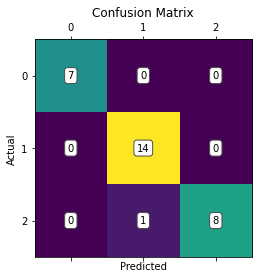

Accuracy:  0.9666666666666667
Precision:
	Class - 0 : 1.0
	Class - 1 : 0.9333333333333333
	Class - 2 : 1.0
Recall:
	Class - 0 : 1.0
	Class - 1 : 1.0
	Class - 2 : 0.8888888888888888
F1-Score:
	Class - 0 : 1.0
	Class - 1 : 0.9655172413793104
	Class - 2 : 0.9411764705882353


In [9]:
dtc.performance_measure(X_test, y_test)